In [44]:
import pickle
import os
import argparse
import torch
from jax import random
import json
import datetime
from src.losses import sse_loss
from src.helper import calculate_exact_ggn, tree_random_normal_like, compute_num_params
from src.sampling.predictive_samplers import sample_predictive, sample_hessian_predictive
from jax import numpy as jnp
import jax
from jax import flatten_util
import matplotlib.pyplot as plt
from src.models import LeNet
from src.data.datasets import get_rotated_fmnist_loaders, get_mnist_ood_loaders
from src.ood_functions.evaluate import evaluate, evaluate_map
from src.ood_functions.metrics import compute_metrics
from src.data import n_classes, MNIST
from collections import defaultdict


### Load All Models

In [45]:
swag_posterior_list = []
swag_posterior_list.append(pickle.load(open("../checkpoints/FMNIST/baselines/SWAG_baseline_0_seed_0_prec_1.0_params.pickle", "rb"))['posterior_samples'])
swag_posterior_list.append(pickle.load(open("../checkpoints/FMNIST/baselines/SWAG_baseline_1_seed_1_prec_1.0_params.pickle", "rb"))['posterior_samples'])
swag_posterior_list.append(pickle.load(open("../checkpoints/FMNIST/baselines/SWAG_baseline_2_seed_2_prec_1.0_params.pickle", "rb"))['posterior_samples'])

last_layer_list = []
last_layer_list.append(pickle.load(open("../checkpoints/FMNIST/baselines/Subnetwork_baseline_0_seed_0_prec_1.0_params.pickle", "rb"))['posterior_samples'])
last_layer_list.append(pickle.load(open("../checkpoints/FMNIST/baselines/Subnetwork_baseline_1_seed_1_prec_1.0_params.pickle", "rb"))['posterior_samples'])
last_layer_list.append(pickle.load(open("../checkpoints/FMNIST/baselines/Subnetwork_baseline_2_seed_2_prec_1.0_params.pickle", "rb"))['posterior_samples'])

diag_list = []
diag_list.append(pickle.load(open("../checkpoints/FMNIST/baselines/Hutchinson_Diag_baseline_0_seed_0_prec_50.0_params.pickle", "rb"))['posterior_samples'])
diag_list.append(pickle.load(open("../checkpoints/FMNIST/baselines/Hutchinson_Diag_baseline_1_seed_1_prec_50.0_params.pickle", "rb"))['posterior_samples'])
diag_list.append(pickle.load(open("../checkpoints/FMNIST/baselines/Hutchinson_Diag_baseline_2_seed_2_prec_50.0_params.pickle", "rb"))['posterior_samples'])



lr_posterior_list = []
lr_posterior_list.append(pickle.load(open("../checkpoints/FMNIST/posterior_samples_deeper_lower_prec_seed_0_seed0_type_non-kernel-eigvals_params.pickle", "rb"))['posterior_samples'])
lr_posterior_list.append(pickle.load(open("../checkpoints/FMNIST/posterior_samples_deeper_lower_prec_seed_1_seed1_type_non-kernel-eigvals_params.pickle", "rb"))['posterior_samples'])
lr_posterior_list.append(pickle.load(open("../checkpoints/FMNIST/posterior_samples_deeper_lower_prec_seed_2_seed2_type_non-kernel-eigvals_params.pickle", "rb"))['posterior_samples'])

posterior_list = []
posterior_list.append(pickle.load(open("../checkpoints/FMNIST/posterior_samples_baseline_seed_0_lowprec_seed0_type_full-ggn_params.pickle", "rb"))['posterior_samples'])
posterior_list.append(pickle.load(open("../checkpoints/FMNIST/posterior_samples_baseline_seed_1_lowprec_seed1_type_full-ggn_params.pickle", "rb"))['posterior_samples'])
posterior_list.append(pickle.load(open("../checkpoints/FMNIST/posterior_samples_baseline_seed_2_lowprec_seed2_type_full-ggn_params.pickle", "rb"))['posterior_samples'])


param_list = []
param_list.append(pickle.load(open("../checkpoints/FMNIST/LeNet/seed_0_seed0_params.pickle", "rb"))['params'])
param_list.append(pickle.load(open("../checkpoints/FMNIST/LeNet/seed_1_seed1_params.pickle", "rb"))['params'])
param_list.append(pickle.load(open("../checkpoints/FMNIST/LeNet/seed_2_seed2_params.pickle", "rb"))['params'])


In [46]:
model = LeNet(output_dim=10, activation="tanh")
model_fn = lambda p, x: model.apply(p, x)

### Rotated FMNIST

In [47]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_lr = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, lr_posterior) in enumerate(zip(param_list, lr_posterior_list)):    
        _, test_loader = get_rotated_fmnist_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, lr_posterior, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-FMNIST"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_lr.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_lr[-1].items()]))
    


R-FMNIST with distribution shift intensity 0


/dtu/p1/hroy/geometric-laplace/geom/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/geometric-laplace/geom/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/geometric-laplace/geom/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


R-FMNIST with distribution shift intensity 0
R-FMNIST with distribution shift intensity 0
conf_mean: 0.9001, nll_mean: 0.2745, acc_mean: 0.9060, conf_std: 0.0006, nll_std: 0.0164, acc_std: 0.0075, brier_mean: 0.1407, ece_mean: 0.1083, mce_mean: 0.7288, brier_std: 0.0055, ece_std: 0.0149, mce_std: 0.0922
R-FMNIST with distribution shift intensity 1
R-FMNIST with distribution shift intensity 1
R-FMNIST with distribution shift intensity 1
conf_mean: 0.7160, nll_mean: 1.0707, acc_mean: 0.6080, conf_std: 0.0124, nll_std: 0.0918, acc_std: 0.0500, brier_mean: 0.5275, ece_mean: 0.1719, mce_mean: 0.6425, brier_std: 0.0600, ece_std: 0.0361, mce_std: 0.0105
R-FMNIST with distribution shift intensity 2
R-FMNIST with distribution shift intensity 2
R-FMNIST with distribution shift intensity 2
conf_mean: 0.7101, nll_mean: 3.8135, acc_mean: 0.2107, conf_std: 0.0150, nll_std: 0.3719, acc_std: 0.0256, brier_mean: 1.2239, ece_mean: 0.4834, mce_mean: 0.9285, brier_std: 0.0683, ece_std: 0.0343, mce_std: 0.

In [48]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_posterior = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, posterior) in enumerate(zip(param_list, posterior_list)):    
        _, test_loader = get_rotated_fmnist_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, posterior, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-FMNIST"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_posterior.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_posterior[-1].items()]))
    


R-FMNIST with distribution shift intensity 0
R-FMNIST with distribution shift intensity 0
R-FMNIST with distribution shift intensity 0
conf_mean: 0.6182, nll_mean: 4.5070, acc_mean: 0.0980, conf_std: 0.0210, nll_std: 0.1604, acc_std: 0.0099, brier_mean: 1.2948, ece_mean: 0.5175, mce_mean: 0.9858, brier_std: 0.0141, ece_std: 0.0132, mce_std: 0.0013
R-FMNIST with distribution shift intensity 1
R-FMNIST with distribution shift intensity 1
R-FMNIST with distribution shift intensity 1
conf_mean: 0.6057, nll_mean: 4.3606, acc_mean: 0.0900, conf_std: 0.0293, nll_std: 0.1711, acc_std: 0.0043, brier_mean: 1.2892, ece_mean: 0.5120, mce_mean: 0.9682, brier_std: 0.0322, ece_std: 0.0266, mce_std: 0.0123
R-FMNIST with distribution shift intensity 2
R-FMNIST with distribution shift intensity 2
R-FMNIST with distribution shift intensity 2
conf_mean: 0.6167, nll_mean: 4.2324, acc_mean: 0.0900, conf_std: 0.0310, nll_std: 0.2301, acc_std: 0.0099, brier_mean: 1.2948, ece_mean: 0.5260, mce_mean: 0.9811, br

In [49]:
eval_args = {}
eval_args["linearised_laplace"] = True
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_lienarised = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, posterior) in enumerate(zip(param_list, posterior_list)):    
        _, test_loader = get_rotated_fmnist_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, posterior, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-FMNIST"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_lienarised.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_lienarised[-1].items()]))
    


R-FMNIST with distribution shift intensity 0
R-FMNIST with distribution shift intensity 0
R-FMNIST with distribution shift intensity 0
conf_mean: 0.8971, nll_mean: 0.4234, acc_mean: 0.8620, conf_std: 0.0030, nll_std: 0.0144, acc_std: 0.0049, brier_mean: 0.2067, ece_mean: 0.1471, mce_mean: 0.7561, brier_std: 0.0059, ece_std: 0.0168, mce_std: 0.0482
R-FMNIST with distribution shift intensity 1
R-FMNIST with distribution shift intensity 1
R-FMNIST with distribution shift intensity 1
conf_mean: 0.7881, nll_mean: 2.0806, acc_mean: 0.4893, conf_std: 0.0084, nll_std: 0.3674, acc_std: 0.0457, brier_mean: 0.7729, ece_mean: 0.3368, mce_mean: 0.8089, brier_std: 0.0807, ece_std: 0.0230, mce_std: 0.0880
R-FMNIST with distribution shift intensity 2
R-FMNIST with distribution shift intensity 2
R-FMNIST with distribution shift intensity 2
conf_mean: 0.7698, nll_mean: 5.0094, acc_mean: 0.2180, conf_std: 0.0092, nll_std: 0.4356, acc_std: 0.0166, brier_mean: 1.2706, ece_mean: 0.5405, mce_mean: 0.8959, br

In [50]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_map = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, params in enumerate(param_list):    
        # params = params_dict['params']
        _, test_loader = get_rotated_fmnist_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate_map(test_loader, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-FMNIST"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_map.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_map[-1].items()]))
    


R-FMNIST with distribution shift intensity 0
R-FMNIST with distribution shift intensity 0
R-FMNIST with distribution shift intensity 0
conf_mean: 0.9144, nll_mean: 0.2785, acc_mean: 0.9040, conf_std: 0.0001, nll_std: 0.0151, acc_std: 0.0059, brier_mean: 0.1430, ece_mean: 0.1249, mce_mean: 0.6091, brier_std: 0.0043, ece_std: 0.0096, mce_std: 0.0328
R-FMNIST with distribution shift intensity 1
R-FMNIST with distribution shift intensity 1
R-FMNIST with distribution shift intensity 1
conf_mean: 0.7532, nll_mean: 1.0843, acc_mean: 0.6253, conf_std: 0.0156, nll_std: 0.1014, acc_std: 0.0491, brier_mean: 0.5225, ece_mean: 0.1914, mce_mean: 0.7646, brier_std: 0.0646, ece_std: 0.0202, mce_std: 0.0708
R-FMNIST with distribution shift intensity 2
R-FMNIST with distribution shift intensity 2
R-FMNIST with distribution shift intensity 2
conf_mean: 0.7416, nll_mean: 4.1592, acc_mean: 0.2100, conf_std: 0.0134, nll_std: 0.3347, acc_std: 0.0251, brier_mean: 1.2598, ece_mean: 0.4894, mce_mean: 0.9424, br

In [51]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_swag = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, swag_posterior) in enumerate(zip(param_list, swag_posterior_list)):    
        _, test_loader = get_rotated_fmnist_loaders(id, data_path="/dtu/p1/hroy/data/", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, swag_posterior, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-FMNIST"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_swag.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_swag[-1].items()]))
    


R-FMNIST with distribution shift intensity 0
R-FMNIST with distribution shift intensity 0
R-FMNIST with distribution shift intensity 0
conf_mean: 0.9250, nll_mean: 0.2594, acc_mean: 0.9113, conf_std: 0.0017, nll_std: 0.0042, acc_std: 0.0057, brier_mean: 0.1347, ece_mean: 0.1524, mce_mean: 0.7519, brier_std: 0.0035, ece_std: 0.0081, mce_std: 0.0675
R-FMNIST with distribution shift intensity 1
R-FMNIST with distribution shift intensity 1
R-FMNIST with distribution shift intensity 1
conf_mean: 0.7622, nll_mean: 1.1446, acc_mean: 0.6273, conf_std: 0.0149, nll_std: 0.0270, acc_std: 0.0266, brier_mean: 0.5254, ece_mean: 0.1890, mce_mean: 0.7455, brier_std: 0.0340, ece_std: 0.0165, mce_std: 0.0298
R-FMNIST with distribution shift intensity 2
R-FMNIST with distribution shift intensity 2
R-FMNIST with distribution shift intensity 2
conf_mean: 0.7395, nll_mean: 4.1972, acc_mean: 0.1953, conf_std: 0.0124, nll_std: 0.0700, acc_std: 0.0152, brier_mean: 1.2658, ece_mean: 0.5185, mce_mean: 0.9214, br

In [52]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_llla = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, ll_laplace) in enumerate(zip(param_list, last_layer_list)):    
        _, test_loader = get_rotated_fmnist_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, ll_laplace, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-FMNIST"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_llla.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_llla[-1].items()]))
    


R-FMNIST with distribution shift intensity 0
R-FMNIST with distribution shift intensity 0
R-FMNIST with distribution shift intensity 0
conf_mean: 0.9142, nll_mean: 0.2801, acc_mean: 0.9013, conf_std: 0.0006, nll_std: 0.0158, acc_std: 0.0062, brier_mean: 0.1442, ece_mean: 0.1305, mce_mean: 0.6727, brier_std: 0.0042, ece_std: 0.0033, mce_std: 0.0830
R-FMNIST with distribution shift intensity 1
R-FMNIST with distribution shift intensity 1
R-FMNIST with distribution shift intensity 1
conf_mean: 0.7554, nll_mean: 1.0872, acc_mean: 0.6193, conf_std: 0.0155, nll_std: 0.1016, acc_std: 0.0490, brier_mean: 0.5234, ece_mean: 0.1946, mce_mean: 0.7209, brier_std: 0.0630, ece_std: 0.0298, mce_std: 0.0231
R-FMNIST with distribution shift intensity 2
R-FMNIST with distribution shift intensity 2
R-FMNIST with distribution shift intensity 2
conf_mean: 0.7432, nll_mean: 4.2295, acc_mean: 0.2067, conf_std: 0.0093, nll_std: 0.3707, acc_std: 0.0197, brier_mean: 1.2659, ece_mean: 0.4979, mce_mean: 0.9136, br

In [53]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_diag = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, diag) in enumerate(zip(param_list, diag_list)):    
        _, test_loader = get_rotated_fmnist_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, diag, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-FMNIST"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_diag.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_diag[-1].items()]))
    


R-FMNIST with distribution shift intensity 0
R-FMNIST with distribution shift intensity 0
R-FMNIST with distribution shift intensity 0
conf_mean: 0.8624, nll_mean: 0.3226, acc_mean: 0.8893, conf_std: 0.0094, nll_std: 0.0216, acc_std: 0.0098, brier_mean: 0.1654, ece_mean: 0.1020, mce_mean: 0.6599, brier_std: 0.0112, ece_std: 0.0031, mce_std: 0.0511
R-FMNIST with distribution shift intensity 1
R-FMNIST with distribution shift intensity 1
R-FMNIST with distribution shift intensity 1
conf_mean: 0.6863, nll_mean: 1.0400, acc_mean: 0.5993, conf_std: 0.0199, nll_std: 0.1219, acc_std: 0.0549, brier_mean: 0.5207, ece_mean: 0.1608, mce_mean: 0.6756, brier_std: 0.0607, ece_std: 0.0139, mce_std: 0.1134
R-FMNIST with distribution shift intensity 2
R-FMNIST with distribution shift intensity 2
R-FMNIST with distribution shift intensity 2
conf_mean: 0.6775, nll_mean: 3.2885, acc_mean: 0.2113, conf_std: 0.0129, nll_std: 0.2985, acc_std: 0.0164, brier_mean: 1.1781, ece_mean: 0.4677, mce_mean: 0.9230, br

In [54]:
from tueplots import bundles
config_plt = bundles.neurips2023()
config_plt['text.usetex'] = False
plt.rcParams.update(config_plt)


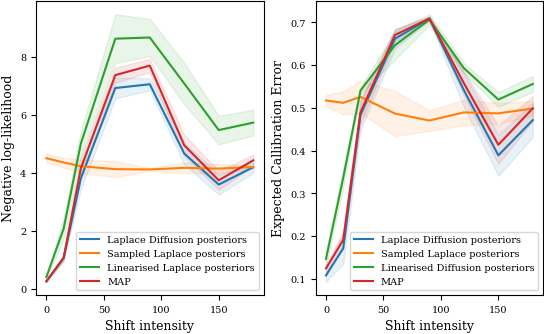

In [55]:
fig, ax = plt.subplots(ncols=2)

uq_metric = 'nll'
lr_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lr])
lr_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lr])
line_1 = ax[0].plot(ids, lr_metric_mean, label="Laplace Diffusion posteriors")
ax[0].fill_between(
    ids, lr_metric_mean - lr_metric_std, lr_metric_mean + lr_metric_std, alpha=0.1, color=line_1[0].get_color()
)
lap_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_posterior])
lap_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_posterior])
line_2 = ax[0].plot(ids, lap_metric_mean, label="Sampled Laplace posteriors")
ax[0].fill_between(
    ids, lap_metric_mean - lap_metric_std, lap_metric_mean + lap_metric_std, alpha=0.1, color=line_2[0].get_color()
)
lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lienarised])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lienarised])
line_3 = ax[0].plot(ids, lin_metric_mean, label="Linearised Laplace posteriors")
ax[0].fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_3[0].get_color()
)

map_metric_mean = jnp.array([map[uq_metric+'_mean'] for map in metrics_map])
map_metric_std = jnp.array([map[uq_metric+'_std'] for map in metrics_map])
line_4 = ax[0].plot(ids, map_metric_mean, label="MAP")
ax[0].fill_between(
    ids, map_metric_mean - map_metric_std, map_metric_mean + map_metric_std, alpha=0.1, color=line_4[0].get_color()
)

# plt.title(uq_metric)
ax[0].set_xlabel("Shift intensity")
ax[0].set_ylabel("Negative log-likelihood")
ax[0].legend()

uq_metric = 'ece'
lr_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lr])
lr_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lr])
line_1 = ax[1].plot(ids, lr_metric_mean, label="Laplace Diffusion posteriors")
ax[1].fill_between(
    ids, lr_metric_mean - lr_metric_std, lr_metric_mean + lr_metric_std, alpha=0.1, color=line_1[0].get_color()
)
lap_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_posterior])
lap_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_posterior])
line_2 = ax[1].plot(ids, lap_metric_mean, label="Sampled Laplace posteriors")
ax[1].fill_between(
    ids, lap_metric_mean - lap_metric_std, lap_metric_mean + lap_metric_std, alpha=0.1, color=line_2[0].get_color()
)
lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lienarised])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lienarised])
line_3 = ax[1].plot(ids, lin_metric_mean, label="Linearised Diffusion posteriors")
ax[1].fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_3[0].get_color()
)

map_metric_mean = jnp.array([map[uq_metric+'_mean'] for map in metrics_map])
map_metric_std = jnp.array([map[uq_metric+'_std'] for map in metrics_map])
line_4 = ax[1].plot(ids, map_metric_mean, label="MAP")
ax[1].fill_between(
    ids, map_metric_mean - map_metric_std, map_metric_mean + map_metric_std, alpha=0.1, color=line_4[0].get_color()
)

# plt.title(uq_metric)
ax[1].set_xlabel("Shift intensity")
ax[1].set_ylabel("Expected Callibration Error")
ax[1].legend()


plt.savefig(f"./rotated_fmnist.pdf")


TypeError: 'list' object is not callable

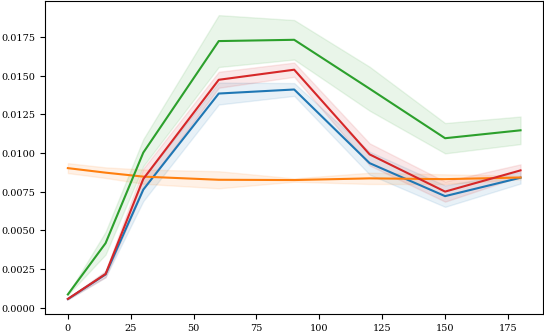

In [56]:
uq_metric = 'nll'
lr_metric_mean = jnp.array([lr[uq_metric+'_mean']/n_datapoint for lr in metrics_lr])
lr_metric_std = jnp.array([lr[uq_metric+'_std']/n_datapoint for lr in metrics_lr])
line_1 = plt.plot(ids, lr_metric_mean, label="Laplace Diffusion posteriors")
plt.fill_between(
    ids, lr_metric_mean - lr_metric_std, lr_metric_mean + lr_metric_std, alpha=0.1, color=line_1[0].get_color()
)
lap_metric_mean = jnp.array([lr[uq_metric+'_mean']/n_datapoint for lr in metrics_posterior])
lap_metric_std = jnp.array([lr[uq_metric+'_std']/n_datapoint for lr in metrics_posterior])
line_2 = plt.plot(ids, lap_metric_mean, label="Sampled Laplace posteriors")
plt.fill_between(
    ids, lap_metric_mean - lap_metric_std, lap_metric_mean + lap_metric_std, alpha=0.1, color=line_2[0].get_color()
)
lin_metric_mean = jnp.array([lr[uq_metric+'_mean']/n_datapoint for lr in metrics_lienarised])
lin_metric_std = jnp.array([lr[uq_metric+'_std']/n_datapoint for lr in metrics_lienarised])
line_3 = plt.plot(ids, lin_metric_mean, label="Linearised Laplace posteriors")
plt.fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_3[0].get_color()
)

map_metric_mean = jnp.array([map[uq_metric+'_mean']/n_datapoint for map in metrics_map])
map_metric_std = jnp.array([map[uq_metric+'_std']/n_datapoint for map in metrics_map])
line_4 = plt.plot(ids, map_metric_mean, label="MAP")
plt.fill_between(
    ids, map_metric_mean - map_metric_std, map_metric_mean + map_metric_std, alpha=0.1, color=line_4[0].get_color()
)

# plt.title(uq_metric)
plt.xlabel("rotations")
plt.ylabel(uq_metric)
plt.legend()
plt.savefig(f"./rotated_fmnist_{uq_metric}.pdf")


TypeError: 'list' object is not callable

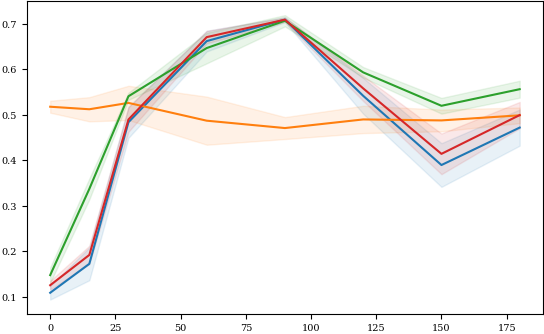

In [57]:
uq_metric = 'ece'
lr_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lr])
lr_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lr])
line_1 = plt.plot(ids, lr_metric_mean, label="Laplace Diffusion posteriors")
plt.fill_between(
    ids, lr_metric_mean - lr_metric_std, lr_metric_mean + lr_metric_std, alpha=0.1, color=line_1[0].get_color()
)
lap_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_posterior])
lap_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_posterior])
line_2 = plt.plot(ids, lap_metric_mean, label="Sampled Laplace posteriors")
plt.fill_between(
    ids, lap_metric_mean - lap_metric_std, lap_metric_mean + lap_metric_std, alpha=0.1, color=line_2[0].get_color()
)
lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lienarised])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lienarised])
line_3 = plt.plot(ids, lin_metric_mean, label="Linearised Laplace posteriors")
plt.fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_3[0].get_color()
)

map_metric_mean = jnp.array([map[uq_metric+'_mean'] for map in metrics_map])
map_metric_std = jnp.array([map[uq_metric+'_std'] for map in metrics_map])
line_4 = plt.plot(ids, map_metric_mean, label="MAP")
plt.fill_between(
    ids, map_metric_mean - map_metric_std, map_metric_mean + map_metric_std, alpha=0.1, color=line_4[0].get_color()
)

# plt.title(uq_metric)
plt.xlabel("Shift intensity")
plt.ylabel(uq_metric)
plt.legend()
plt.savefig(f"./rotated_fmnist_{uq_metric}.pdf")


In [ ]:
import pandas as pd
metrics_dict = ['conf', 'nll', 'acc', 'brier', 'ece', 'mce']
method_list = ["Laplace Diffusion", "Sampled Laplace", "Linearised Laplace", "SWAG", "Last-Layer Laplace", "Diagonal Laplace", "MAP"]
method_dict = {"Laplace Diffusion":metrics_lr, "Sampled Laplace": metrics_posterior,"Linearised Laplace":metrics_lienarised, "SWAG": metrics_swag,
               "Last-Layer Laplace":metrics_llla,"Diagonal Laplace": metrics_diag, "MAP":metrics_map}

df_data = {metric: ["{:.3f}".format(method_dict[dic][0][metric+'_mean']) + u"\u00B1" + "{:.3f}".format(method_dict[dic][0][metric+'_std']) for dic in method_dict] for metric in metrics_dict}
# df_data = {k: ["{:.3f}".format(dic[metric+'_mean']) + u"\u00B1" + "{:.3f}".format(dic[metric+'_std'])  for dic in method_dict[k][1:] for metric in metrics_dict] for k in method_dict}

df = pd.DataFrame.from_dict(df_data, orient='index', columns=method_list)
df = df.T


/tmp/ipykernel_821796/117465716.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
df

,conf,nll,acc,brier,ece,mce
Laplace Diffusion,0.900±0.001,0.275±0.016,0.906±0.007,0.141±0.006,0.108±0.015,0.729±0.092
Sampled Laplace,0.618±0.021,4.507±0.160,0.098±0.010,1.295±0.014,0.518±0.013,0.986±0.001
Linearised Laplace,0.897±0.003,0.423±0.014,0.862±0.005,0.207±0.006,0.147±0.017,0.756±0.048
SWAG,0.925±0.002,0.259±0.004,0.911±0.006,0.135±0.004,0.152±0.008,0.752±0.067
Last-Layer Laplace,0.914±0.001,0.280±0.016,0.901±0.006,0.144±0.004,0.131±0.003,0.673±0.083
Diagonal Laplace,0.862±0.009,0.323±0.022,0.889±0.010,0.165±0.011,0.102±0.003,0.660±0.051
MAP,0.914±0.000,0.279±0.015,0.904±0.006,0.143±0.004,0.125±0.010,0.609±0.033


In [ ]:
print(df.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.3f}".format,
))  


\begin{tabular}{lllllll}
\toprule
 & conf & nll & acc & brier & ece & mce \\
\midrule
Laplace Diffusion & 0.900±0.001 & 0.275±0.016 & 0.906±0.007 & 0.141±0.006 & 0.108±0.015 & 0.729±0.092 \\
Sampled Laplace & 0.618±0.021 & 4.507±0.160 & 0.098±0.010 & 1.295±0.014 & 0.518±0.013 & 0.986±0.001 \\
Linearised Laplace & 0.897±0.003 & 0.423±0.014 & 0.862±0.005 & 0.207±0.006 & 0.147±0.017 & 0.756±0.048 \\
SWAG & 0.925±0.002 & 0.259±0.004 & 0.911±0.006 & 0.135±0.004 & 0.152±0.008 & 0.752±0.067 \\
Last-Layer Laplace & 0.914±0.001 & 0.280±0.016 & 0.901±0.006 & 0.144±0.004 & 0.131±0.003 & 0.673±0.083 \\
Diagonal Laplace & 0.862±0.009 & 0.323±0.022 & 0.889±0.010 & 0.165±0.011 & 0.102±0.003 & 0.660±0.051 \\
MAP & 0.914±0.000 & 0.279±0.015 & 0.904±0.006 & 0.143±0.004 & 0.125±0.010 & 0.609±0.033 \\
\bottomrule
\end{tabular}




| Laplace Diffusion | 0.900±0.001 | 137.269±8.185 | 0.906±0.007 | 0.141±0.006 | 0.108±0.015 | 0.729±0.092 |
| Sampled Laplace | 0.618±0.021 | 2253.498±80.176 | 0.098±0.010 | 1.295±0.014 | 0.518±0.013 | 0.986±0.001 |
| Linearised Laplace | 0.897±0.003 | 211.683±7.200 | 0.862±0.005 | 0.207±0.006 | 0.147±0.017 | 0.756±0.048 |
| MAP | 0.914±0.000 | 139.251±7.530 | 0.904±0.006 | 0.143±0.004 | 0.125±0.010 | 0.609±0.033 |


In [ ]:
import pandas as pd
metrics_dict = ['nll', 'ece', 'acc']
method_list = ["Laplace Diffusion", "Sampled Laplace", "Linearised Laplace", "SWAG", "Last-Layer Laplace", "MAP"]
method_dict = {"Laplace Diffusion":metrics_lr, "Sampled Laplace": metrics_posterior,"Linearised Laplace":metrics_lienarised, "SWAG": metrics_swag,
               "Last-Layer Laplace":metrics_llla, "MAP":metrics_map}

df_data = {metric: [float(method_dict[dic][0][metric+'_mean']) for dic in method_dict] for metric in metrics_dict}
# df_data = {k: ["{:.3f}".format(dic[metric+'_mean']) + u"\u00B1" + "{:.3f}".format(dic[metric+'_std'])  for dic in method_dict[k][1:] for metric in metrics_dict] for k in method_dict}

df = pd.DataFrame.from_dict(df_data, orient='index', columns=method_list)
df = df.T

diffusion_dict = {k: df_data[k][0] for k in metrics_dict}
la_dict = {k: df_data[k][1] for k in metrics_dict}
lin_dict = {k: df_data[k][2] for k in metrics_dict}
swag_dict = {k: df_data[k][3] for k in metrics_dict}
llla_dict = {k: df_data[k][4] for k in metrics_dict}
map_dict = {k: df_data[k][5] for k in metrics_dict}

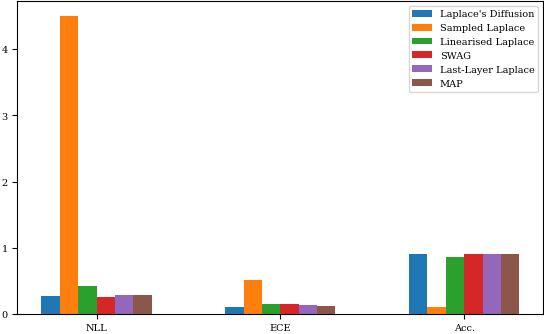

In [ ]:
keys = ['NLL', 'ECE', 'Acc.']
Y1 = list(diffusion_dict.values())
Y2 = list(la_dict.values())
Y3 = list(lin_dict.values())
Y4 = list(swag_dict.values())
Y5 = list(llla_dict.values())
Y6 = list(map_dict.values())
X_axis = jnp.arange(len(keys))


plt.bar(X_axis - 0.25, Y1, 0.1, label = "Laplace's Diffusion")
plt.bar(X_axis - 0.15, Y2, 0.1, label = 'Sampled Laplace')
plt.bar(X_axis - 0.05, Y3, 0.1, label='Linearised Laplace')
plt.bar(X_axis + 0.05, Y4, 0.1, label='SWAG')
plt.bar(X_axis + 0.15, Y5, 0.1, label='Last-Layer Laplace')
plt.bar(X_axis + 0.25, Y6, 0.1, label='MAP')

plt.xticks(X_axis, keys)
plt.xlabel = keys
plt.legend()
plt.show()

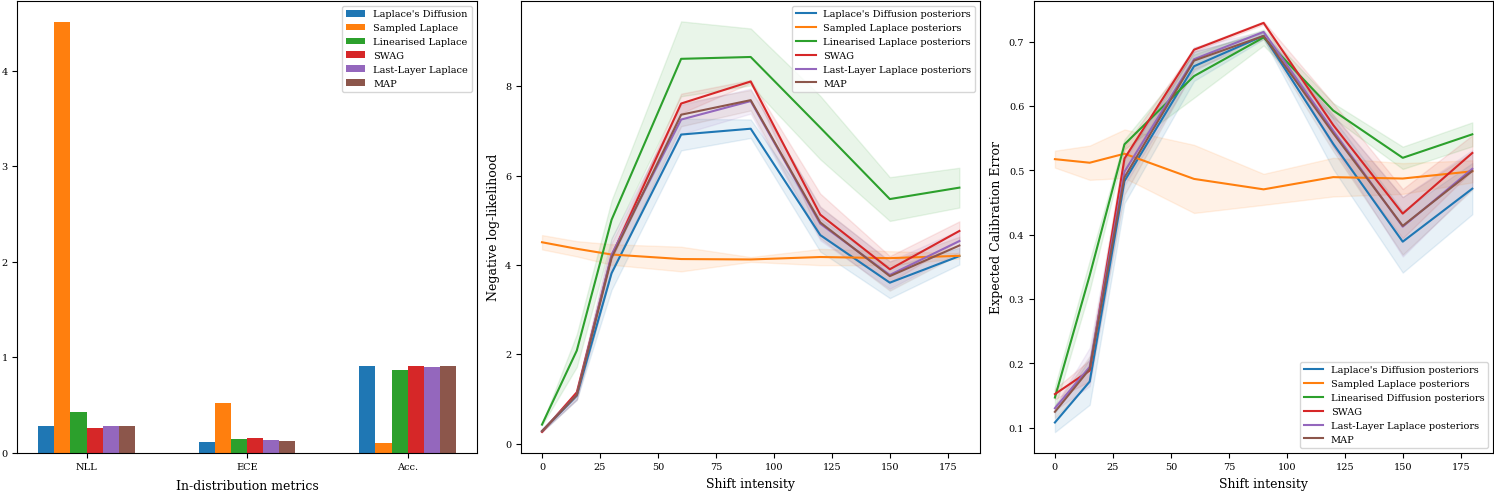

In [58]:
# fig, ax = plt.subplots(ncols=2)

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

keys = ['NLL', 'ECE', 'Acc.']
Y1 = list(diffusion_dict.values())
Y2 = list(la_dict.values())
Y3 = list(lin_dict.values())
Y4 = list(swag_dict.values())
Y5 = list(llla_dict.values())
Y6 = list(map_dict.values())
X_axis = jnp.arange(len(keys))


ax[0].bar(X_axis - 0.25, Y1, 0.1, label = "Laplace's Diffusion")
ax[0].bar(X_axis - 0.15, Y2, 0.1, label = 'Sampled Laplace')
ax[0].bar(X_axis - 0.05, Y3, 0.1, label='Linearised Laplace')
ax[0].bar(X_axis + 0.05, Y4, 0.1, label='SWAG')
ax[0].bar(X_axis + 0.15, Y5, 0.1, label='Last-Layer Laplace')
ax[0].bar(X_axis + 0.25, Y6, 0.1, label='MAP')

ax[0].set_xticks(X_axis, keys)
ax[0].xlabel = keys
ax[0].legend()
ax[0].set_title("In-distribution metrics", y=-0.1)

# plt.savefig('./in_distribution_metrics.pdf')



uq_metric = 'nll'
lr_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lr])
lr_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lr])
line_1 = ax[1].plot(ids, lr_metric_mean, label="Laplace's Diffusion posteriors")
ax[1].fill_between(
    ids, lr_metric_mean - lr_metric_std, lr_metric_mean + lr_metric_std, alpha=0.1, color=line_1[0].get_color()
)
lap_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_posterior])
lap_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_posterior])
line_2 = ax[1].plot(ids, lap_metric_mean, label="Sampled Laplace posteriors")
ax[1].fill_between(
    ids, lap_metric_mean - lap_metric_std, lap_metric_mean + lap_metric_std, alpha=0.1, color=line_2[0].get_color()
)
lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lienarised])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lienarised])
line_3 = ax[1].plot(ids, lin_metric_mean, label="Linearised Laplace posteriors")
ax[1].fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_3[0].get_color()
)


lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_swag])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_swag])
line_4 = ax[1].plot(ids, lin_metric_mean, label="SWAG")
ax[1].fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_4[0].get_color()
)

lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_llla])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_llla])
line_5 = ax[1].plot(ids, lin_metric_mean, label="Last-Layer Laplace posteriors")
ax[1].fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_5[0].get_color()
)

# lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_diag])
# lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_diag])
# line_6 = ax[0].plot(ids, lin_metric_mean, label="Diagonal Laplace posteriors")
# ax[0].fill_between(
#     ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_6[0].get_color()
# )


map_metric_mean = jnp.array([map[uq_metric+'_mean'] for map in metrics_map])
map_metric_std = jnp.array([map[uq_metric+'_std'] for map in metrics_map])
line_7 = ax[1].plot(ids, map_metric_mean, label="MAP")
ax[1].fill_between(
    ids, map_metric_mean - map_metric_std, map_metric_mean + map_metric_std, alpha=0.1, color=line_7[0].get_color()
)
# plt.title(uq_metric)
ax[1].set_xlabel("Shift intensity")
ax[1].set_ylabel("Negative log-likelihood")
ax[1].legend()

uq_metric = 'ece'
lr_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lr])
lr_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lr])
line_1 = ax[2].plot(ids, lr_metric_mean, label="Laplace's Diffusion posteriors")
ax[2].fill_between(
    ids, lr_metric_mean - lr_metric_std, lr_metric_mean + lr_metric_std, alpha=0.1, color=line_1[0].get_color()
)
lap_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_posterior])
lap_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_posterior])
line_2 = ax[2].plot(ids, lap_metric_mean, label="Sampled Laplace posteriors")
ax[2].fill_between(
    ids, lap_metric_mean - lap_metric_std, lap_metric_mean + lap_metric_std, alpha=0.1, color=line_2[0].get_color()
)
lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lienarised])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lienarised])
line_3 = ax[2].plot(ids, lin_metric_mean, label="Linearised Diffusion posteriors")
ax[2].fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_3[0].get_color()
)

lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_swag])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_swag])
line_4 = ax[2].plot(ids, lin_metric_mean, label="SWAG")
ax[2].fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_4[0].get_color()
)

lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_llla])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_llla])
line_5 = ax[2].plot(ids, lin_metric_mean, label="Last-Layer Laplace posteriors")
ax[2].fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_5[0].get_color()
)

# lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_diag])
# lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_diag])
# line_6 = ax[1].plot(ids, lin_metric_mean, label="Diagonal Laplace posteriors")
# ax[1].fill_between(
#     ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_6[0].get_color()
# )


map_metric_mean = jnp.array([map[uq_metric+'_mean'] for map in metrics_map])
map_metric_std = jnp.array([map[uq_metric+'_std'] for map in metrics_map])
line_7 = ax[2].plot(ids, map_metric_mean, label="MAP")
ax[2].fill_between(
    ids, map_metric_mean - map_metric_std, map_metric_mean + map_metric_std, alpha=0.1, color=line_7[0].get_color()
)

# plt.title(uq_metric)
ax[2].set_xlabel("Shift intensity")
ax[2].set_ylabel("Expected Calibration Error")
ax[2].legend()


plt.savefig(f"./apdx_rotated_fmnist.pdf")


### FMNIST OOD

In [34]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = ["FMNIST", "MNIST", "EMNIST", "KMNIST"]
n_datapoint=500
ood_batch_size = 50
metrics_lr = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, lr_posterior) in enumerate(zip(param_list, lr_posterior_list)):    
        _, test_loader = get_mnist_ood_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, lr_posterior, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="FMNIST-OOD"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_lr.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_lr[-1].items()]))
    


FMNIST-OOD - dataset: FMNIST
FMNIST-OOD - dataset: FMNIST
FMNIST-OOD - dataset: FMNIST
conf_mean: 0.9001, nll_mean: 0.2745, acc_mean: 0.9060, conf_std: 0.0006, nll_std: 0.0164, acc_std: 0.0075
FMNIST-OOD - dataset: MNIST
FMNIST-OOD - dataset: MNIST
FMNIST-OOD - dataset: MNIST
conf_mean: 0.7335, nll_mean: 5.3317, acc_mean: 0.1280, conf_std: 0.0386, nll_std: 0.3429, acc_std: 0.0204, auroc_mean: 0.7592, fpr95_mean: 0.7540, auroc_std: 0.0449, fpr95_std: 0.0721
FMNIST-OOD - dataset: EMNIST
FMNIST-OOD - dataset: EMNIST
FMNIST-OOD - dataset: EMNIST
conf_mean: 0.7296, nll_mean: 5.5923, acc_mean: 0.1120, conf_std: 0.0203, nll_std: 0.1017, acc_std: 0.0028, auroc_mean: 0.7414, fpr95_mean: 0.7387, auroc_std: 0.0101, fpr95_std: 0.0490
FMNIST-OOD - dataset: KMNIST
FMNIST-OOD - dataset: KMNIST
FMNIST-OOD - dataset: KMNIST
conf_mean: 0.7458, nll_mean: 5.7671, acc_mean: 0.1267, conf_std: 0.0118, nll_std: 0.1375, acc_std: 0.0057, auroc_mean: 0.7491, fpr95_mean: 0.7713, auroc_std: 0.0229, fpr95_std: 0.02

In [35]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = ["FMNIST", "MNIST", "EMNIST", "KMNIST"]
n_datapoint=500
ood_batch_size = 50
metrics_posterior = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, posterior) in enumerate(zip(param_list, posterior_list)):   
        _, test_loader = get_mnist_ood_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, posterior, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="FMNIST-OOD"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_posterior.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_posterior[-1].items()]))
    


FMNIST-OOD - dataset: FMNIST
FMNIST-OOD - dataset: FMNIST
FMNIST-OOD - dataset: FMNIST
conf_mean: 0.6182, nll_mean: 4.5070, acc_mean: 0.0980, conf_std: 0.0210, nll_std: 0.1604, acc_std: 0.0099
FMNIST-OOD - dataset: MNIST
FMNIST-OOD - dataset: MNIST
FMNIST-OOD - dataset: MNIST
conf_mean: 0.5966, nll_mean: 4.1603, acc_mean: 0.0987, conf_std: 0.0271, nll_std: 0.1033, acc_std: 0.0235, auroc_mean: 0.4946, fpr95_mean: 0.9433, auroc_std: 0.0372, fpr95_std: 0.0077
FMNIST-OOD - dataset: EMNIST
FMNIST-OOD - dataset: EMNIST
FMNIST-OOD - dataset: EMNIST
conf_mean: 0.5927, nll_mean: 4.2066, acc_mean: 0.0980, conf_std: 0.0258, nll_std: 0.1402, acc_std: 0.0156, auroc_mean: 0.5027, fpr95_mean: 0.9567, auroc_std: 0.0364, fpr95_std: 0.0105
FMNIST-OOD - dataset: KMNIST
FMNIST-OOD - dataset: KMNIST
FMNIST-OOD - dataset: KMNIST
conf_mean: 0.5977, nll_mean: 4.3230, acc_mean: 0.0967, conf_std: 0.0240, nll_std: 0.1467, acc_std: 0.0109, auroc_mean: 0.4933, fpr95_mean: 0.9440, auroc_std: 0.0335, fpr95_std: 0.01

In [36]:
eval_args = {}
eval_args["linearised_laplace"] = True
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = ["FMNIST", "MNIST", "EMNIST", "KMNIST"]
n_datapoint=500
ood_batch_size = 50
metrics_linearised = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, posterior) in enumerate(zip(param_list, posterior_list)):   
        _, test_loader = get_mnist_ood_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, posterior, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="FMNIST-OOD"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_linearised.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_linearised[-1].items()]))
    


FMNIST-OOD - dataset: FMNIST
FMNIST-OOD - dataset: FMNIST
FMNIST-OOD - dataset: FMNIST
conf_mean: 0.8971, nll_mean: 0.4234, acc_mean: 0.8620, conf_std: 0.0030, nll_std: 0.0144, acc_std: 0.0049
FMNIST-OOD - dataset: MNIST
FMNIST-OOD - dataset: MNIST
FMNIST-OOD - dataset: MNIST
conf_mean: 0.8167, nll_mean: 8.8588, acc_mean: 0.0880, conf_std: 0.0216, nll_std: 0.7334, acc_std: 0.0134, auroc_mean: 0.6250, fpr95_mean: 0.8787, auroc_std: 0.0500, fpr95_std: 0.0164
FMNIST-OOD - dataset: EMNIST
FMNIST-OOD - dataset: EMNIST
FMNIST-OOD - dataset: EMNIST
conf_mean: 0.8129, nll_mean: 8.4961, acc_mean: 0.1100, conf_std: 0.0031, nll_std: 0.1646, acc_std: 0.0059, auroc_mean: 0.6285, fpr95_mean: 0.8567, auroc_std: 0.0135, fpr95_std: 0.0057
FMNIST-OOD - dataset: KMNIST
FMNIST-OOD - dataset: KMNIST
FMNIST-OOD - dataset: KMNIST
conf_mean: 0.8156, nll_mean: 8.3935, acc_mean: 0.1167, conf_std: 0.0145, nll_std: 0.1425, acc_std: 0.0210, auroc_mean: 0.6239, fpr95_mean: 0.8660, auroc_std: 0.0204, fpr95_std: 0.02

In [37]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = ["FMNIST", "MNIST", "EMNIST", "KMNIST"]
n_datapoint=500
ood_batch_size = 50
metrics_diag = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, diag) in enumerate(zip(param_list, diag_list)):    
        _, test_loader = get_mnist_ood_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, diag, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="FMNIST-OOD"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_diag.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_diag[-1].items()]))
    


FMNIST-OOD - dataset: FMNIST
FMNIST-OOD - dataset: FMNIST
FMNIST-OOD - dataset: FMNIST
conf_mean: 0.8624, nll_mean: 0.3226, acc_mean: 0.8893, conf_std: 0.0094, nll_std: 0.0216, acc_std: 0.0098
FMNIST-OOD - dataset: MNIST
FMNIST-OOD - dataset: MNIST
FMNIST-OOD - dataset: MNIST
conf_mean: 0.6520, nll_mean: 4.4441, acc_mean: 0.1167, conf_std: 0.0330, nll_std: 0.1927, acc_std: 0.0034, auroc_mean: 0.7674, fpr95_mean: 0.7280, auroc_std: 0.0325, fpr95_std: 0.0396
FMNIST-OOD - dataset: EMNIST
FMNIST-OOD - dataset: EMNIST
FMNIST-OOD - dataset: EMNIST
conf_mean: 0.6821, nll_mean: 4.7577, acc_mean: 0.1080, conf_std: 0.0187, nll_std: 0.0669, acc_std: 0.0049, auroc_mean: 0.7195, fpr95_mean: 0.7580, auroc_std: 0.0330, fpr95_std: 0.0033
FMNIST-OOD - dataset: KMNIST
FMNIST-OOD - dataset: KMNIST
FMNIST-OOD - dataset: KMNIST
conf_mean: 0.6962, nll_mean: 4.9029, acc_mean: 0.1353, conf_std: 0.0249, nll_std: 0.1761, acc_std: 0.0047, auroc_mean: 0.7284, fpr95_mean: 0.8227, auroc_std: 0.0322, fpr95_std: 0.02

In [38]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = ["FMNIST", "MNIST", "EMNIST", "KMNIST"]
n_datapoint=500
ood_batch_size = 50
metrics_swag = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, swag_posterior) in enumerate(zip(param_list, swag_posterior_list)):    
        _, test_loader = get_mnist_ood_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, swag_posterior, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="FMNIST-OOD"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_swag.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_swag[-1].items()]))
    


FMNIST-OOD - dataset: FMNIST
FMNIST-OOD - dataset: FMNIST
FMNIST-OOD - dataset: FMNIST
conf_mean: 0.9250, nll_mean: 0.2594, acc_mean: 0.9113, conf_std: 0.0017, nll_std: 0.0042, acc_std: 0.0057
FMNIST-OOD - dataset: MNIST
FMNIST-OOD - dataset: MNIST
FMNIST-OOD - dataset: MNIST
conf_mean: 0.7271, nll_mean: 5.8238, acc_mean: 0.1313, conf_std: 0.0131, nll_std: 0.1446, acc_std: 0.0068, auroc_mean: 0.8173, fpr95_mean: 0.6993, auroc_std: 0.0150, fpr95_std: 0.0308
FMNIST-OOD - dataset: EMNIST
FMNIST-OOD - dataset: EMNIST
FMNIST-OOD - dataset: EMNIST
conf_mean: 0.7628, nll_mean: 6.4037, acc_mean: 0.1240, conf_std: 0.0281, nll_std: 0.2995, acc_std: 0.0071, auroc_mean: 0.7689, fpr95_mean: 0.7447, auroc_std: 0.0263, fpr95_std: 0.0494
FMNIST-OOD - dataset: KMNIST
FMNIST-OOD - dataset: KMNIST
FMNIST-OOD - dataset: KMNIST
conf_mean: 0.7773, nll_mean: 6.4418, acc_mean: 0.1300, conf_std: 0.0073, nll_std: 0.1429, acc_std: 0.0118, auroc_mean: 0.7823, fpr95_mean: 0.7947, auroc_std: 0.0099, fpr95_std: 0.01

In [39]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = ["FMNIST", "MNIST", "EMNIST", "KMNIST"]
n_datapoint=500
ood_batch_size = 50
metrics_llla = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, ll_posterior) in enumerate(zip(param_list, last_layer_list)):   
        _, test_loader = get_mnist_ood_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, ll_posterior, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="FMNIST-OOD"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_llla.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_llla[-1].items()]))
    


FMNIST-OOD - dataset: FMNIST
FMNIST-OOD - dataset: FMNIST
FMNIST-OOD - dataset: FMNIST
conf_mean: 0.9142, nll_mean: 0.2801, acc_mean: 0.9013, conf_std: 0.0006, nll_std: 0.0158, acc_std: 0.0062
FMNIST-OOD - dataset: MNIST
FMNIST-OOD - dataset: MNIST
FMNIST-OOD - dataset: MNIST
conf_mean: 0.7569, nll_mean: 5.8688, acc_mean: 0.1193, conf_std: 0.0193, nll_std: 0.3812, acc_std: 0.0191, auroc_mean: 0.7614, fpr95_mean: 0.7547, auroc_std: 0.0310, fpr95_std: 0.0229
FMNIST-OOD - dataset: EMNIST
FMNIST-OOD - dataset: EMNIST
FMNIST-OOD - dataset: EMNIST
conf_mean: 0.7603, nll_mean: 6.2224, acc_mean: 0.1160, conf_std: 0.0168, nll_std: 0.1560, acc_std: 0.0118, auroc_mean: 0.7353, fpr95_mean: 0.7480, auroc_std: 0.0178, fpr95_std: 0.0328
FMNIST-OOD - dataset: KMNIST
FMNIST-OOD - dataset: KMNIST
FMNIST-OOD - dataset: KMNIST
conf_mean: 0.7724, nll_mean: 6.3501, acc_mean: 0.1280, conf_std: 0.0075, nll_std: 0.1577, acc_std: 0.0118, auroc_mean: 0.7471, fpr95_mean: 0.7847, auroc_std: 0.0213, fpr95_std: 0.00

In [40]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = ["FMNIST", "MNIST", "EMNIST", "KMNIST"]
n_datapoint=500
ood_batch_size = 50
metrics_map = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, params in enumerate(param_list):   
        # params = params_dict['params'] 
        _, test_loader = get_mnist_ood_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate_map(test_loader, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="FMNIST-OOD"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_map.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_map[-1].items()]))
    


FMNIST-OOD - dataset: FMNIST
FMNIST-OOD - dataset: FMNIST
FMNIST-OOD - dataset: FMNIST
conf_mean: 0.9144, nll_mean: 0.2785, acc_mean: 0.9040, conf_std: 0.0001, nll_std: 0.0151, acc_std: 0.0059
FMNIST-OOD - dataset: MNIST
FMNIST-OOD - dataset: MNIST
FMNIST-OOD - dataset: MNIST
conf_mean: 0.7589, nll_mean: 5.8599, acc_mean: 0.1313, conf_std: 0.0188, nll_std: 0.3060, acc_std: 0.0260, auroc_mean: 0.7575, fpr95_mean: 0.7660, auroc_std: 0.0319, fpr95_std: 0.0269
FMNIST-OOD - dataset: EMNIST
FMNIST-OOD - dataset: EMNIST
FMNIST-OOD - dataset: EMNIST
conf_mean: 0.7621, nll_mean: 6.2511, acc_mean: 0.1093, conf_std: 0.0180, nll_std: 0.2018, acc_std: 0.0047, auroc_mean: 0.7299, fpr95_mean: 0.7553, auroc_std: 0.0146, fpr95_std: 0.0408
FMNIST-OOD - dataset: KMNIST
FMNIST-OOD - dataset: KMNIST
FMNIST-OOD - dataset: KMNIST
conf_mean: 0.7727, nll_mean: 6.3379, acc_mean: 0.1207, conf_std: 0.0100, nll_std: 0.1410, acc_std: 0.0066, auroc_mean: 0.7435, fpr95_mean: 0.7867, auroc_std: 0.0239, fpr95_std: 0.00

In [41]:
import pandas as pd
metrics_dict = ['conf', 'auroc']
method_list = ["Laplace Diffusion", "Sampled Laplace", "Linearised Laplace", "SWAG", "Last-Layer Laplace", "Diagonal Laplace", "MAP"]
method_dict = {"Laplace Diffusion":metrics_lr, "Sampled Laplace": metrics_posterior,"Linearised Laplace":metrics_linearised, "SWAG": metrics_swag,
               "Last-Layer Laplace":metrics_llla,"Diagonal Laplace": metrics_diag, "MAP":metrics_map}
mux = pd.MultiIndex.from_product([ids[1:], metrics_dict])
# df_data = {k: [dic[metric+'_mean'] for metric in metrics_dict for dic in method_dict[k][1:]] for k in method_dict}
df_data = {k: ["{:.3f}".format(dic[metric+'_mean']) + u"\u00B1" + "{:.3f}".format(dic[metric+'_std'])  for dic in method_dict[k][1:] for metric in metrics_dict] for k in method_dict}

df = pd.DataFrame.from_dict(df_data, orient='index',
                       columns=mux)


In [42]:
df

MNIST                    EMNIST               \
                           conf        auroc         conf        auroc   
Laplace Diffusion   0.734±0.039  0.759±0.045  0.730±0.020  0.741±0.010   
Sampled Laplace     0.597±0.027  0.495±0.037  0.593±0.026  0.503±0.036   
Linearised Laplace  0.817±0.022  0.625±0.050  0.813±0.003  0.628±0.013   
SWAG                0.727±0.013  0.817±0.015  0.763±0.028  0.769±0.026   
Last-Layer Laplace  0.757±0.019  0.761±0.031  0.760±0.017  0.735±0.018   
Diagonal Laplace    0.652±0.033  0.767±0.032  0.682±0.019  0.719±0.033   
MAP                 0.759±0.019  0.757±0.032  0.762±0.018  0.730±0.015   

                         KMNIST               
                           conf        auroc  
Laplace Diffusion   0.746±0.012  0.749±0.023  
Sampled Laplace     0.598±0.024  0.493±0.033  
Linearised Laplace  0.816±0.014  0.624±0.020  
SWAG                0.777±0.007  0.782±0.010  
Last-Layer Laplace  0.772±0.008  0.747±0.021  
Diagonal Laplace    0.696±0.025  0.728±0.032  
MAP                 0.773±0.010  0.743±0.024

In [43]:
print(df.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.3f}".format,
))  


\begin{tabular}{lllllll}
\toprule
 & \multicolumn{2}{r}{MNIST} & \multicolumn{2}{r}{EMNIST} & \multicolumn{2}{r}{KMNIST} \\
 & conf & auroc & conf & auroc & conf & auroc \\
\midrule
Laplace Diffusion & 0.734±0.039 & 0.759±0.045 & 0.730±0.020 & 0.741±0.010 & 0.746±0.012 & 0.749±0.023 \\
Sampled Laplace & 0.597±0.027 & 0.495±0.037 & 0.593±0.026 & 0.503±0.036 & 0.598±0.024 & 0.493±0.033 \\
Linearised Laplace & 0.817±0.022 & 0.625±0.050 & 0.813±0.003 & 0.628±0.013 & 0.816±0.014 & 0.624±0.020 \\
SWAG & 0.727±0.013 & 0.817±0.015 & 0.763±0.028 & 0.769±0.026 & 0.777±0.007 & 0.782±0.010 \\
Last-Layer Laplace & 0.757±0.019 & 0.761±0.031 & 0.760±0.017 & 0.735±0.018 & 0.772±0.008 & 0.747±0.021 \\
Diagonal Laplace & 0.652±0.033 & 0.767±0.032 & 0.682±0.019 & 0.719±0.033 & 0.696±0.025 & 0.728±0.032 \\
MAP & 0.759±0.019 & 0.757±0.032 & 0.762±0.018 & 0.730±0.015 & 0.773±0.010 & 0.743±0.024 \\
\bottomrule
\end{tabular}



| Laplace Diffusion | 0.734±0.039 | 0.759±0.045 | 0.730±0.020 | 0.741±0.010 | 0.746±0.012 | 0.749±0.023 |
| Laplace Approximation | 0.597±0.027 | 0.495±0.037 | 0.593±0.026 | 0.503±0.036 | 0.598±0.024 | 0.493±0.033 |
| Linearised Laplace | 0.817±0.022 | 0.625±0.050 | 0.813±0.003 | 0.628±0.013 | 0.816±0.014 | 0.624±0.020 |
| MAP | 0.759±0.019 | 0.757±0.032 | 0.762±0.018 | 0.730±0.015 | 0.773±0.010 | 0.743±0.024 |
